In [1]:
from utils import train_utils, data_utils, anchor_utils, bbox_utils
import tensorflow as tf
from config import *
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'
tf.random.set_seed(42)

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as error:
        print(error)

1 Physical GPUs, 1 Logical GPUs


In [4]:
model, _, _, _ = train_utils.get_model()

Model: YOLOv4
Loss Metric: YOLOv4Loss
make new model


In [5]:
tf.random.set_seed(42)
dataloader = data_utils.DataLoader(batch_size=BATCH_SIZE)
# dataloader = DataLoader(batch_size=BATCH_SIZE)
test_dataset = dataloader('val', use_label=True)

/home/dblab/anaconda3/envs/tf28/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: coco val
./data/coco/val.tfrecord is exist


In [6]:
data = next(iter(test_dataset))

In [7]:
images, s_grids, m_grids, l_grids, labels = data

In [8]:
def draw(image, p1, p2, color, width, box=True):
    if box:
        cv2.rectangle(image, p1,p2, color, width)
    else:
        c = ((p1 + p2)*0.5).astype(np.int32)
        cv2.circle(image, c, width, color, width)

18 0 0 1


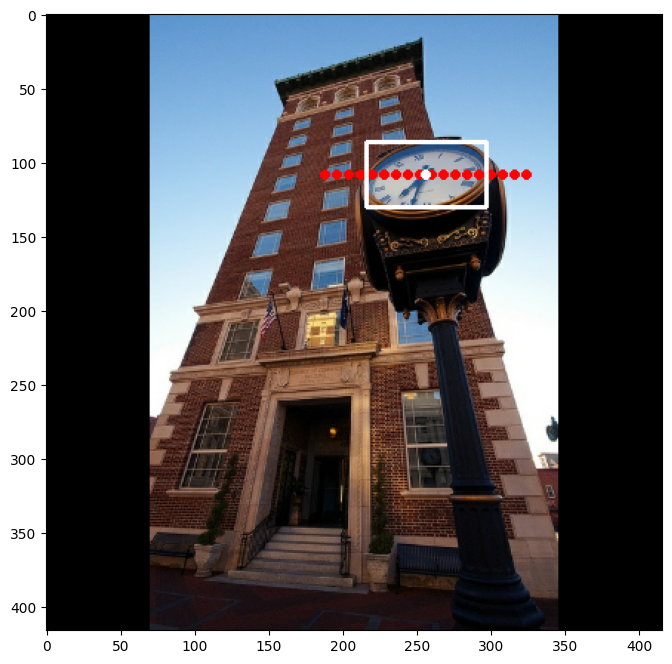

In [19]:
plt.figure(figsize=(8,8))
c_image = np.zeros((416,416,3), np.float32)
for i, (image, s_grid, m_grid, l_grid, label) in enumerate(zip(images.numpy()*255, s_grids, m_grids, l_grids, labels)):
    if i==0:
        image = image.astype(np.int32)

        ss = 0 
        for y, y_grid in enumerate(s_grid.numpy()):
            for x, x_grid in enumerate(y_grid):
                for a, grid in enumerate(x_grid):
                    if grid[4] != 0:
                        p1 = (grid[..., :2] - 0.5 * grid[..., 2:4]).astype(np.int32)
                        p2 = (grid[..., :2] + 0.5 * grid[..., 2:4]).astype(np.int32)
                        draw(image, p1, p2, (255, 0, 0), 2)
                        cv2.circle(image, (x*8+4, y*8+4), 2, (255, 0, 0), 2)
                        ss += 1
                        c_image[y*8+4, x*8+4] = (255., 0., 0.)
        
        mm = 0
        for y, y_grid in enumerate(m_grid.numpy()):
            for x, x_grid in enumerate(y_grid):
                for a, grid in enumerate(x_grid):
                    if grid[4] != 0:
                        p1 = (grid[..., :2] - 0.5 * grid[..., 2:4]).astype(np.int32)
                        p2 = (grid[..., :2] + 0.5 * grid[..., 2:4]).astype(np.int32)
                        draw(image, p1, p2, (0, 255, 0), 2)
                        cv2.circle(image, (x*16+8, y*16+8), 2, (0, 255, 0), 2)
                        mm += 1
                        c_image[y*16+8, x*16+8] = (0., 255., 0.)

        ll = 0
        for y, y_grid in enumerate(l_grid.numpy()):
            for x, x_grid in enumerate(y_grid):
                for a, grid in enumerate(x_grid):
                    if grid[4] != 0:
                        p1 = (grid[..., :2] - 0.5 * grid[..., 2:4]).astype(np.int32)
                        p2 = (grid[..., :2] + 0.5 * grid[..., 2:4]).astype(np.int32)
                        draw(image, p1, p2, (0, 0, 255), 2)
                        cv2.circle(image, (x*32+16, y*32+16), 2, (0, 0, 255), 2)
                        ll += 1
                        c_image[y*32+16, x*32+16] = (0., 0., 255.)

        gg = 0
        for g in label.numpy():
            if g[4] != 0:
                cp = (g[..., :2] + g[..., 2:4])*0.5
                cv2.circle(image, cp.astype(np.int32), 2, (255, 255, 255), 2)
                p1 = g[..., :2].astype(np.int32)
                p2 = g[..., 2:4].astype(np.int32)
                draw(image, p1, p2, (255, 255, 255), 2)
                gg += 1
        plt.imshow(image)
        print(ss, mm, ll, gg)
        break
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


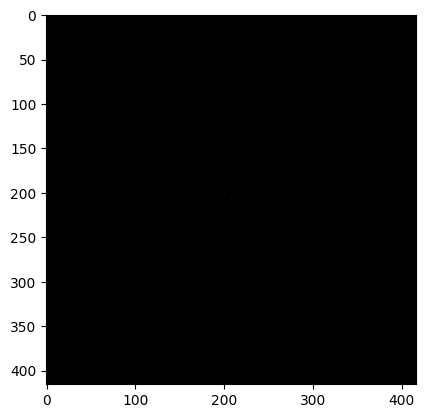

In [11]:
plt.imshow(c_image)
plt.show()

In [12]:
out = model(images[0:1])

In [13]:
anchors = anchor_utils.get_anchors_xywh(ANCHORS, STRIDES, IMAGE_SIZE)

[0.0004186]
[0.00040743]
[0.00023829]
[0.0003903]
[0.00035564]
[0.00026099]
[0.00036632]
[0.00037571]
[0.00020474]
[0.00035879]
[0.0003893]
[0.00019868]
[0.0003831]
[0.00042216]
[0.00023295]
[0.00043852]
[0.00045434]
[0.00025696]
[0.00048643]
[0.00047222]
[0.00027996]
[0.00047636]
[0.00048362]
[0.0002649]
[0.00048866]
[0.00048826]
[0.00027016]
[0.00041363]
[0.00045329]
[0.00023425]
[0.0004268]
[0.00042947]
[0.00023264]
[0.00039813]
[0.00041059]
[0.00023215]
[0.00039146]
[0.00039335]
[0.00022974]
[0.00039119]
[0.00038287]
[0.00022532]
[0.00039545]
[0.00036631]
[0.00022489]
[0.0004159]
[0.00039515]
[0.0002364]
[0.00043651]
[0.00041211]
[0.00025183]
[0.0004247]
[0.00041676]
[0.00024492]
[0.00036984]
[0.0003707]
[0.00020917]
[0.00044484]
[0.00044356]
[0.00024974]
[0.00040777]
[0.0003563]
[0.00024351]
[0.0003845]
[0.00044032]
[0.00023836]
[0.00035471]
[0.00036426]
[0.00020015]
[0.00035136]
[0.00038952]
[0.00020114]
[0.00038508]
[0.00040896]
[0.00018516]
[0.00040831]
[0.00043113]
[0.00022027

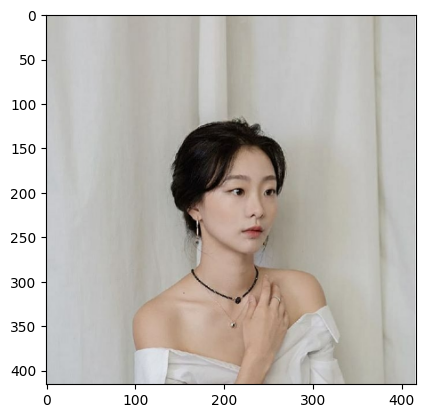

In [20]:
count = 0
i = (images[0].numpy()*255).astype(np.uint8)
for g, anchor, stride in zip(out, anchors, STRIDES):
    raw_bbox = g[..., :4]
    raw_conf = g[..., 4:5]
    raw_prob = g[..., 5:]
    pred_xy = tf.sigmoid(raw_bbox[..., :2]) + anchor[..., :2]
    pred_wh = tf.exp(raw_bbox[..., 2:4]) * anchor[..., 2:4]
    pred_bbox = tf.concat([pred_xy, pred_wh], -1) * stride
    pred_conf = tf.sigmoid(raw_conf)
    pred_prob = tf.argmax(tf.sigmoid(raw_prob), -1)[..., None]

    best_c = 0.
    best_box = [[0,0],[0,0]]

    for b, c, p in zip(pred_bbox.numpy().reshape(-1, 4), pred_conf.numpy().reshape(-1, 1), pred_prob.numpy().reshape(-1, 1)):
        print(c)
        if c>0.1:
            p1 = (b[:2] - 0.5 * b[2:4]).astype(np.int32)
            p2 = (b[:2] + 0.5 * b[2:4]).astype(np.int32)
            cv2.rectangle(i, p1, p2, (255, 0, 0), 1)
            count += 1
            if best_c < c:
                best_c = c
                best_box = [p1, p2]

    cv2.rectangle(i, best_box[0], best_box[1], (0, 0, 255), 1)
print(count)
plt.imshow(i)
plt.show()

0


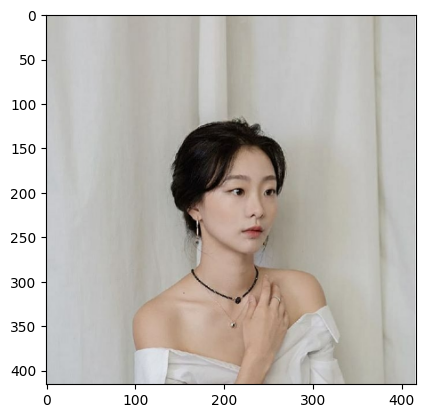

In [15]:
from utils import post_processing
anchors_flat = list(map(lambda x: tf.reshape(x, [-1,4]), anchor_utils.get_anchors_xywh(ANCHORS, STRIDES, IMAGE_SIZE)))

batch_processed_preds = post_processing.prediction_to_bbox(out, anchors_flat, 1, STRIDES, NUM_CLASSES, IMAGE_SIZE)
count = 0
best_cc = 0
best_bbox = [[0,0], [0,0]]
i = (images[0].numpy()*255).astype(np.uint8)

for pred in batch_processed_preds[0].numpy():
    bb = pred[..., :4]
    cc = pred[..., 4:5]
    pp = pred[..., 5:]

    pp1 = bb[..., :2].astype(np.int32)
    pp2 = bb[..., 2:4].astype(np.int32)
    if cc>0.1:
        print(cc)
        cv2.rectangle(i, pp1, pp2, (255, 0, 0), 1)
        count += 1
    if best_cc < cc:
        best_cc = cc
        
        best_bbox = [pp1, pp2]
cv2.rectangle(i, best_box[0], best_box[1], (0, 0, 255), 1)
print(count)
plt.imshow(i)
plt.show()

In [16]:
batch_processed_preds

<tf.Tensor: shape=(1, 10647, 6), dtype=float32, numpy=
array([[[0.0000000e+00, 0.0000000e+00, 1.4106658e+01, 1.8311098e+01,
         1.8982185e-04, 3.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 2.2507248e+01, 2.7183811e+01,
         1.7508080e-04, 2.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 3.3736454e+01, 3.2529232e+01,
         5.5185450e-05, 2.0000000e+00],
        ...,
        [3.2934647e+02, 3.2045132e+02, 4.1600000e+02, 4.1600000e+02,
         5.8701413e-04, 3.0000000e+00],
        [2.9566891e+02, 3.0765198e+02, 4.1600000e+02, 4.1600000e+02,
         8.3528354e-04, 2.0000000e+00],
        [2.8877386e+02, 2.7584558e+02, 4.1600000e+02, 4.1600000e+02,
         2.5451062e-03, 0.0000000e+00]]], dtype=float32)>